# Time series analysis

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

np.random.seed(1234)

Let's begin by considering an AR(1) series

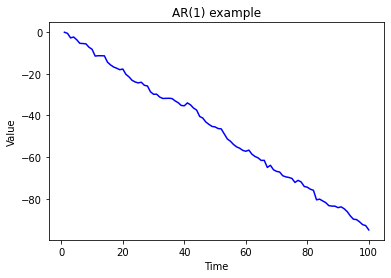

In [203]:
# Simulated AR(1) model: x_t = x_{t-1} - 1

w = np.random.normal(0,1,size=(100))
t = np.arange(1,101,1)
y_sim = [0]

for i in range(1,100):
    y_sim.append(y_sim[i-1]-1+w[i-1])
    
plt.plot(t,y_sim,'b-')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('AR(1) example')

plt.show()

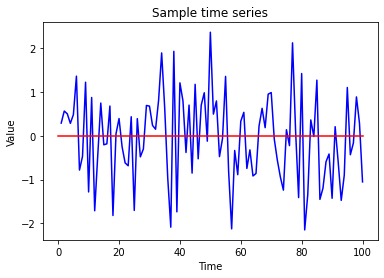

In [204]:
# Sample time series
y = np.random.normal(size=(100))

plt.plot(t,y,'b-')
plt.plot([0,100],[0,0],'r-')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Sample time series')

plt.show()

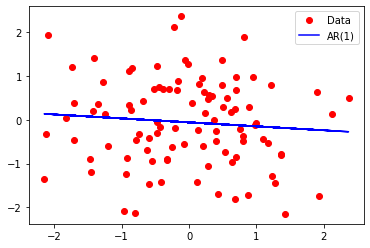

In [205]:
# Lag 1 model

plt.plot(y[0:99],y[1:100],'ro', label='Data')

reg = LinearRegression().fit(y[0:99].reshape((99,1)), y[1:100])
m = reg.coef_[0]
c = reg.intercept_
plt.plot(y[0:99],m*y[0:99]+c,'b-', label='AR(1)')

plt.legend()

plt.show()


Clearly the lag 1 model is very inaccurate. Let's try to see the sample ACF plot

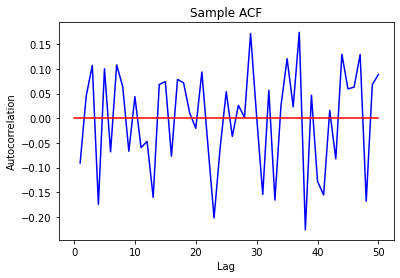

In [206]:
# Sample ACF
lim = 50
L = np.zeros(shape=(lim))
x = np.arange(1,lim+1,1)

for i in range(1,lim+1):
    reg = LinearRegression().fit(y[0:100-i].reshape((100-i,1)), y[i:100])
    L[i-1] = reg.coef_[0]

plt.plot(x,L,'b-')
plt.plot([0,lim],[0,0],'r-')

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Sample ACF')

plt.show()

The ACM does not seem to shrink, so an AR(1) model is inappropriate here. How about first difference?

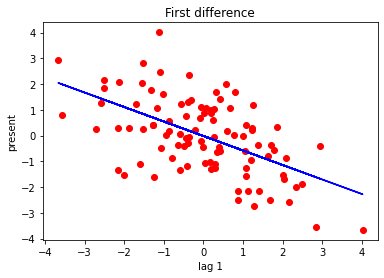

In [207]:
# First difference model
d = y[1:100] - y[0:99]

plt.plot(d[0:98],d[1:99],'ro')
reg = LinearRegression().fit(d[0:98].reshape((98,1)), d[1:99])
m = reg.coef_[0]
c = reg.intercept_
plt.plot(d[0:99],m*d[0:99]+c,'b-', label='AR(1)')

plt.xlabel('lag 1')
plt.ylabel('present')
plt.title('First difference')

plt.show()

This model also does not seem satisfactory. Let's try MA model. We first give an example.

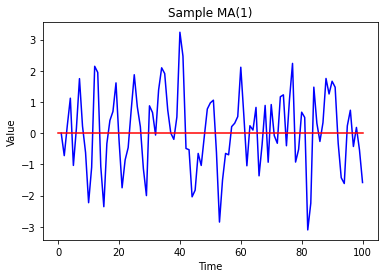

In [209]:
# MA(1) sample: x_t = 3 + w_t - w_{t-1}

y_sim = np.zeros(100)
y_sim[0] = 0

for i in range(1,100):
    y_sim[i] = w[i] + w[i-1]
    
plt.plot(t,y_sim,'b-')
plt.plot([0,100],[0,0],'r-')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Sample MA(1)')

plt.show()

Best parameter: -0.980000
Training error: 8.069458


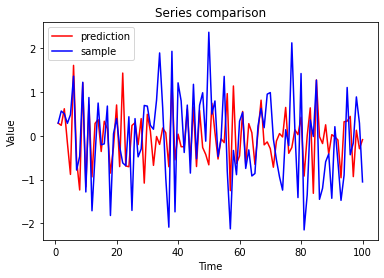

In [210]:
# MA(1) on data
# Choose parameter by MLE and hand-tuning
# Tune by minimizing training error

mu = np.sum(y)/100
sigma2 = (y.T@y-mu**2)/99
candidate = np.arange(-0.99,1,0.001)
best = candidate[0]
error_min = 10000

for i1 in range(len(candidate)):
    theta = candidate[i1]
    error = 0
    for rep in range(10):
        w_theta = np.random.normal(0,sigma2/(1+theta**2),size=(100))
        for i in range(1,100):
            error += abs(y[i]-mu-w_theta[i]-theta*w_theta[i-1])/10
        if error < error_min:
            error_min = error
            best = theta

# Plot best MA(1)

print('Best parameter: %f' % best)
print('Training error: %f' % error_min)

y_pred = [y[0]]
w_theta = np.random.normal(0,sigma2/(1+best**2),size=(100))
for i in range(1,100):
    y_pred.append(mu + w_theta[i] + best*w_theta[i-1])
    
plt.plot(t,y_pred,'r-',label='prediction')
plt.plot(t,y,'b-',label='sample')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Series comparison')
plt.legend()

plt.show()

We see that the MA(1) model is quite good. How about higher order MA model?

Best parameters: (0.119863,-1.712329)
Training error: 72.114928


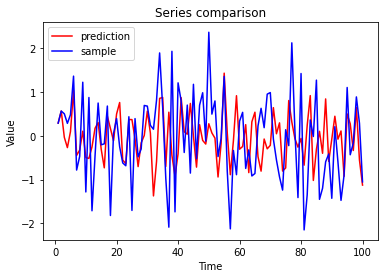

In [211]:
# MA(2)
# For invertibility, we tune by inverting values for grid search

mu = np.sum(y)/100
sigma2 = (y.T@y-mu**2)/99
candidate = np.arange(-0.99,1,0.01)
best = [0,0]
error_min = 10000

for i1 in range(len(candidate)):
    r1 = candidate[i1]
    if r1==0:
        continue
    for i2 in range(len(candidate)):
        error = 0
        r2 = candidate[i2]
        if r2==0:
            continue
        theta1 = 1/r1 + 1/r2
        theta2 = 1/(r1*r2)
        w_theta = np.random.normal(0,sigma2/(1+theta1**2+theta2**2),size=(100))
        for i in range(2,100):
            error += abs(y[i]-mu-w_theta[i]-theta1*w_theta[i-1]-theta2*w_theta[i-2])
        if error < error_min:
            error_min = error
            best[0] = theta1
            best[1] = theta2
            
# Plot best MA(2)

print('Best parameters: (%f,%f)' % (best[0],best[1]))
print('Training error: %f' % error_min)

y_pred = [y[0],y[1]]
w_theta = np.random.normal(0,sigma2/(1+best[0]**2+best[1]**2),size=(100))
for i in range(2,100):
    y_pred.append(mu + w_theta[i] + best[0]*w_theta[i-1] + best[1]*w_theta[i-2])
    
plt.plot(t,y_pred,'r-',label='prediction')
plt.plot(t,y,'b-',label='sample')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Series comparison')
plt.legend()

plt.show()

As we can see, this seems to be of higher degree. We can see it becomes worse for degree 3

In [149]:
# Fitness function to evaluate an individual
# reciprocal of average training error of 10 trials
def fitness(ind,y):
    theta1,theta2,theta3 = ind
    mu = np.sum(y)/100
    sigma2 = (y.T@y-mu**2)/99
    error = 0
    for rep in range(10):
        w_theta = np.random.normal(0,sigma2/(1+theta1**2+theta2**2+theta3**2),size=(100))
        for i in range(3,100):
            error += abs(y[i] - mu - w_theta[i] - theta1 * w_theta[i-1] - theta2 * w_theta[i-2] - theta3 * w_theta[i-3])/20
    fitness = 1/error
    return fitness

In [177]:
# function for a MA(3) model
# Unlike MA(2), triple for loop is slow
# We use genetic algorithm

def MA3(init_pop,n_gen,y):
    mu = np.sum(y)/100
    sigma2 = (y.T@y-mu**2)/99
    error_min = 10000

    pop = np.zeros(shape=(2,init_pop,3)) #First dimension to store different generations
    for i in range(init_pop):
        for j in range(3):
            while pop[0,i,j] == 0:
                pop[0,i,j] = np.random.uniform(-1,1)

    for gen in range(n_gen):

        # Fitness of individuals
        fit = []
        for i in range(init_pop):
            fit.append(fitness(pop[gen%2,i,:],y))
        fit = np.array(fit/sum(fit))
        fit = np.cumsum(fit)
    
        # Next generation
        for i in range(init_pop):
            # Probability for operations:
            # First entry: 0.5,0.3,0.2 for reproduction, cross over and mutation repspectively
            # Second and third entry: Choose offspring
            prob = np.random.uniform(0,1,size=(3))
            if prob[0] < 0.5:
                # Reproduction
                for j in range(init_pop):
                    if prob[1] > fit[j]:
                        pop[1-int(gen%2),i,:] = pop[int(gen%2),j,:]
            elif prob[0] < 0.8:
                # Loop again if only one more offspring is needed
                if i == init_pop - 1:
                    prob = np.random.uniform(0,1,size=(3))
                    i = i-1
                    continue
                # Cross over
                digit = np.random.randint(2,10,size=(1))
                for j in range(init_pop):
                    if prob[1] > fit[j]:
                        pop[1-int(gen%2),i,:] = pop[int(gen%2),j,:]
                    if prob[2] > fit[j]:
                        pop[1-int(gen%2),i+1,:] = pop[int(gen%2),j,:]
                head1 = (pop[1-int(gen%2),i,:]*(10**digit))%1/(10**digit)
                tail1 = pop[1-int(gen%2),i,:] - head1
                head2 = (pop[1-int(gen%2),i+1,:]*(10**digit))%1/(10**digit)
                tail2 = pop[1-int(gen%2),i+1,:] - head2
                pop[1-int(gen%2),i,:] = head1 + tail2
                pop[1-int(gen%2),i+1,:] = head2 + tail1
                # Skip next individual
                i = i+1
            else:
                # Mutation 
                digit = np.random.randint(2,10,size=(1))
                for j in range(init_pop):
                    if prob[1] > fit[j]:
                        pop[1-int(gen%2),i,:] = pop[int(gen%2),j,:]
                pop[1-int(gen%2),i,:] += np.random.normal(0,1/(10**(digit)),size=(3))
    
    fit = []
    for i in range(init_pop):
        fit.append(fitness(pop[gen%2,i,:],y))
    fit = np.array(fit/sum(fit))
    i = np.argmax(fit)

    # Return the result
    error = 0
    y_pred = [y[0],y[1],y[2]]
    theta1,theta2,theta3 = pop[(int(gen)+1)%2,i,:]
    w_theta = np.random.normal(0,sigma2/(1+theta1**2+theta2**2+theta3**2),size=(100))
    for i in range(3,100):
        y_pred.append(mu + w_theta[i] + theta1 * w_theta[i-1] + theta2 * w_theta[i-2] + theta3 * w_theta[i-3])
        error += abs(y[i] - y_pred[i])

    res = {'pred':y_pred,'error':error}
    
    return res

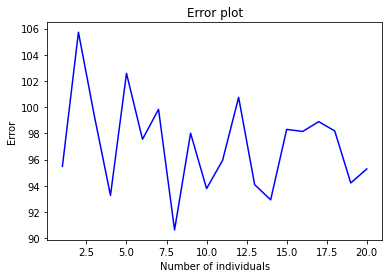

In [189]:
# Plot of number of individuals against error with 100 generations
error = np.zeros(shape=(20))
for init_pop in range(1,21):
    for rep in range(5):
        res = MA3(init_pop,50,y)
        error[init_pop-1] += res['error']/5
    
plt.plot(t[0:20],error,'b-')

plt.xlabel('Number of individuals')
plt.ylabel('Error')
plt.title('Error plot')

plt.show()

We see that this also does not seem to be a good model.